This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html).

# Setup
---

In [8]:
# %pip install -e ..
# %pip install scikit-optimize

In [6]:
import numpy as np
import pandas as pd

from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_objective
from skopt import dump
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs

In [7]:
CONFIG = {"s":  0.97}

## Hugging face login

In [3]:
## download & upload saved model weights
from huggingface_hub import hf_hub_download, HfApi, login
api = HfApi()
login()

# Policy Optimization
---

## Objective fns

In [12]:
msy_space = [Real(0.001, 0.25, name='mortality')]
esc_space = [Real(0.001, 0.80, name='escapement')]
cr_space  = [
    Real(0.00001, 1, name='radius'),
    Real(0.00001, np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]

@use_named_args(msy_space)
def msy_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = Msy(env=eval_env, mortality = x['mortality'])
    mean, sd = evaluate_policy(agent, Monitor(eval_env), n_eval_episodes=100)
    return -mean

@use_named_args(esc_space)
def esc_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = ConstEsc(env=eval_env, escapement = x['escapement'])
    mean, sd = evaluate_policy(agent, Monitor(eval_env), n_eval_episodes=100)
    return -mean

@use_named_args(cr_space)
def cr_obj(**x):
    theta = x["theta"]
    radius = x["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
    mean, sd = evaluate_policy(agent, Monitor(eval_env), n_eval_episodes=100)
    return -mean  



## Optimization

### MSY

Minimum at spproximately `mortality = 0.036`, with a (minus) reward value of `-344`.

In [15]:
%%time
msy_gp = gp_minimize(msy_obj, msy_space, n_calls = 50, verbose=True, n_jobs=-1)
msy_gp.fun, msy_gp.x

(-344.81508420000006, [0.03679360865276369])

<Axes: >

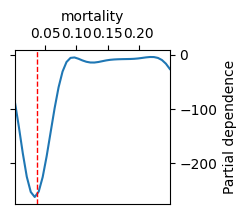

In [16]:
plot_objective(msy_gp)

In [17]:
%%time
msy_gbrt = gbrt_minimize(msy_obj, msy_space, n_calls = 50, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

(-413.97059970999993, [0.026082308394732884])

<Axes: >

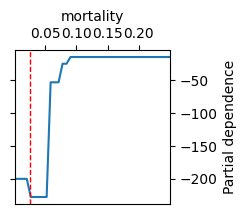

In [18]:
plot_objective(msy_gbrt)

### Esc

Optimal escapement is approximately `escapement = 0.133` with a (minus) reward value of about `-250`.

In [19]:
%%time
esc_gp = gp_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

(-399.8290314899999, [0.17183492119923788])

<Axes: >

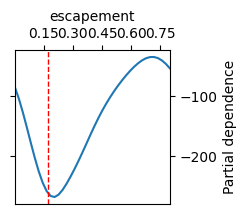

In [20]:
plot_objective(esc_gp)

In [21]:
%%time
esc_gbrt = gbrt_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

(-445.35083130000004, [0.1596852959040506])

<Axes: >

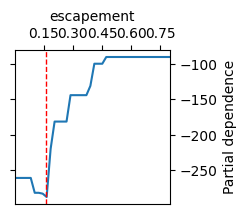

In [22]:
plot_objective(esc_gbrt)

### CR

In [13]:
%%time
cr_gp = gp_minimize(cr_obj, cr_space, n_calls = 50, verbose=True, n_jobs=-1)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.8765
Function value obtained: -351.7318
Current minimum: -351.7318
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.7790
Function value obtained: -222.6689
Current minimum: -351.7318
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.7518
Function value obtained: -174.7706
Current minimum: -351.7318
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.0518
Function value obtained: -340.0497
Current minimum: -351.7318
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.8816
Function value obtained: -251.9900
Current minimum: -351.7318


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 1e-05, 1.0] before, using random point [0.3803735619256906, 0.501488617712397, 0.11082626422314903]
  warnings.warn(


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 15.0832
Function value obtained: -306.8230
Current minimum: -410.9384
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 15.1915
Function value obtained: -192.0073
Current minimum: -410.9384
Iteration No: 49 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 1e-05, 1.0] before, using random point [0.7877568546929663, 0.7095084957907133, 0.24825060528452686]
  warnings.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 15.1035
Function value obtained: -102.9234
Current minimum: -410.9384
Iteration No: 50 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 1e-05, 1.0] before, using random point [0.5156288173888501, 0.18829691640463697, 0.8405282125608928]
  warnings.warn(


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 15.0984
Function value obtained: -354.1497
Current minimum: -410.9384
CPU times: user 14min 7s, sys: 11min 53s, total: 26min 1s
Wall time: 12min 45s


(-410.93840314,
 [0.21946183895274754, 0.44335860308748737, 0.41059228240857215])

<Axes: >

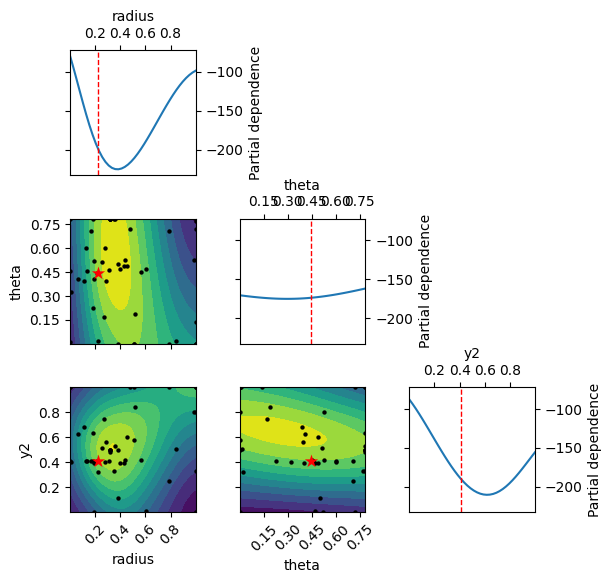

In [14]:
plot_objective(cr_gp)

In [17]:
%%time
cr_gbrt = gp_minimize(cr_obj, cr_space, n_calls = 150, verbose=True, n_jobs=-1)
cr_gbrt.fun, cr_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.4285
Function value obtained: -145.5092
Current minimum: -145.5092
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.4036
Function value obtained: -376.5553
Current minimum: -376.5553
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.1200
Function value obtained: -61.3406
Current minimum: -376.5553
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.1149
Function value obtained: -103.9941
Current minimum: -376.5553
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.9661
Function value obtained: -82.7326
Current minimum: -376.5553
It

(-454.69024843, [0.37243753649830236, 0.42278680991848616, 0.4207223170684818])

<Axes: >

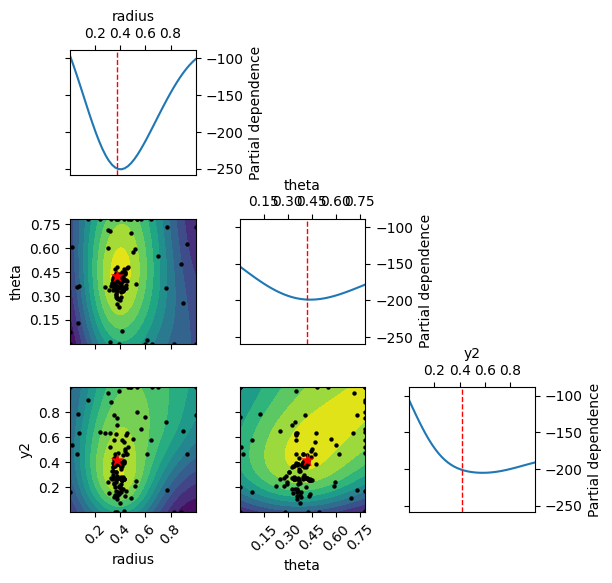

In [18]:
plot_objective(cr_gbrt)

In [ ]:
# -> (-62.08484130000001, [0.058590822346937174])

In [ ]:
path = "../saved_agents/"
fname = "msy_gp.pkl"
dump(msy_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

In [ ]:
%%time
msy_gbrt = gbrt_minimize(msy_fun, [(0.02, 0.15)], n_calls = 100, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

In [ ]:
# -> (-57.168266599999995, [0.05811506272614242])

In [ ]:
path = "../saved_agents/"
fname = "msy_gbrt.pkl"
dump(msy_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

In [ ]:
plot_objective(msy_gp)

## Const Escapement

In [ ]:
def esc_fun(x):
    agent = ConstEsc(escapement=x[0])
    mean, sd = evaluate_policy(agent, Monitor(env), n_eval_episodes=100)
    return -mean

In [ ]:
%%time
esc_gp = gp_minimize(esc_fun, [(0.002, 0.25)], n_calls = 500, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

In [ ]:
path = "../saved_agents/"
fname = "esc_gp.pkl"
dump(esc_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

In [ ]:
%%time
esc_gbrt = gbrt_minimize(esc_fun, [(0.02, 0.15)], n_calls = 100, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

In [ ]:
plot_objective(esc_gp)

In [ ]:
dump(esc_gbrt, "../saved_agents/esc_gbrt.pkl")

## Precationary Rule (piecewise linear)

In [ ]:
from skopt.space import Real
from skopt.utils import use_named_args

space  = [Real(0.00001, 1, name='radius'),
          Real(0.00001, np.pi/4.00001, name='theta'),
          Real(0, 0.2, name='y2')]

@use_named_args(space)
def g(**params):

    theta = params["theta"]
    radius = params["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    
    assert x1 <= x2, ("CautionaryRule error: x1 < x2, " + str(x1) + ", ", str(x2) )

    agent = CautionaryRule(x1 = x1, x2 =  x2, y2 = params["y2"])
    mean, sd = evaluate_policy(agent, Monitor(env), n_eval_episodes=100)
    return -mean        


In [ ]:
%%time
g_gp = gp_minimize(g, space, n_calls = 300, verbose=True, n_jobs=-1)


In [ ]:
path = "../saved_agents/"
fname = "cr_gp.pkl"
dump(g_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

In [ ]:
# -> (-64.06042883, [0.041136645707627796, 0.7853961999069485, 0.12010362758045579])

In [ ]:
%%time
g_gbrt = gbrt_minimize(g, space, n_calls = 300, verbose=True, n_jobs=-1)


In [ ]:
# -> (-64.49868469, [0.06184391109700299, 0.3296309210963565, 0.12990125226898555])

In [ ]:
path = "../saved_agents/"
fname = "cr_gbrt.pkl"
dump(g_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

In [ ]:
g_gp.fun, g_gp.x, g_gbrt.fun, g_gbrt.x

In [ ]:
res = g_gp

radius = res.x[0]
theta = res.x[1]
y2 = res.x[2]
x1 = np.sin(theta) * radius
x2 = np.cos(theta) * radius

agent = CautionaryRule(x1, x2, y2)
evaluate_policy(agent, Monitor(env), n_eval_episodes=100)


In [ ]:
plot_objective(g_gp)

# Reward statistics

## RL agents

In [ ]:
revision = "d21aac2cf7acd04485ae97c4194954cdba038ce2"
ppo_1obs = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/PPO-Asm-v0-1.zip", revision=revision)
ppo_2obs = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/PPO-Asm2o-v0-1.zip", revision=revision)

In [ ]:
from rl4fisheries.utils.sb3 import load_sb3_agent

ppo_agent = load_sb3_agent(algo = "PPO", env = Asm(), weights = ppo_1obs)
ppo2o_agent = load_sb3_agent(algo = "PPO", env = Asm2o(), weights = ppo_2obs)

## Fixed policy agents

In [ ]:
msy_agent = Msy(mortality = 0.05811506272614242)

In [ ]:
radius, theta, y2 = [0.041136645707627796, 0.7853961999069485, 0.12010362758045579] 

x1 = radius * np.sin(theta)
x2 = radius * np.cos(theta)

cr_agent = CautionaryRule(x1=x1, x2=x2, y2=y2)

## Generate reward data

In [ ]:
msy_rews = evaluate_policy(
    model=msy_agent, 
    env=Asm(), 
    n_eval_episodes=300,
    return_episode_rewards=True,
)[0]

In [ ]:
cr_rews = evaluate_policy(
    model=cr_agent, 
    env=Asm(), 
    n_eval_episodes=300,
    return_episode_rewards=True,
)[0]

In [ ]:
ppo_rews = evaluate_policy(
    model=ppo_agent, 
    env=Asm(), 
    n_eval_episodes=300,
    return_episode_rewards=True,
)[0]

In [ ]:
ppo2o_rews = evaluate_policy(
    model=ppo2o_agent, 
    env=Asm2o(), 
    n_eval_episodes=300,
    return_episode_rewards=True,
)[0]

In [ ]:
msy_df = pd.DataFrame({"strategy": "msy", "reward":msy_rews})
cr_df = pd.DataFrame({"strategy": "cr", "reward":cr_rews})
ppo_df = pd.DataFrame({"strategy": "ppo", "reward":ppo_rews})
ppo2o_df = pd.DataFrame({"strategy": "ppo_2obs", "reward":ppo2o_rews})

rew_df = pd.concat([msy_df, cr_df, ppo_df, ppo2o_df], ignore_index=True)

In [ ]:
from plotnine import ggplot, aes, geom_density
(
    ggplot(rew_df, aes(x="reward", fill="strategy")) +#  geom_bar(stat="bin", binwidth=1, alpha=0.5) + 
    geom_density(alpha=0.5) 
)